# 10 Minutes to DeepGraph

This is a short introduction to DeepGraph. In the following, we demonstrate DeepGraph's core functionalities by a toy data-set, "flying balls".

First of all, we need to import some packages

In [1]:
# for plots
import matplotlib.pyplot as plt

# the usual
import numpy as np
import pandas as pd

import deepgraph as dg

# notebook display
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 6
pd.options.display.max_rows = 10
pd.set_option('expand_frame_repr', False)

**Loading Toy Data**

In [2]:
v = pd.read_csv('flying_balls.csv', index_col=0)
print(v)

      time            x          y  ball_id
0        0  1692.000000   0.000000        0
1        0  8681.000000   0.000000        1
2        0   490.000000   0.000000        2
3        0  7439.000000   0.000000        3
4        0  4998.000000   0.000000        4
...    ...          ...        ...      ...
1163    45  2812.552734  16.503178       39
1164    46  5686.915998  14.161693       10
1165    46  3161.729086  19.381823       14
1166    46  5594.233413  57.701712       37
1167    47  5572.216748  20.588750       37

[1168 rows x 4 columns]


The data consists of 1168 space-time measurements of 50 different toy balls in two-dimensional space. Each space-time measurement (i.e. row of ``v``) represents a **node**.

Let's plot the data such that each ball has it's own color

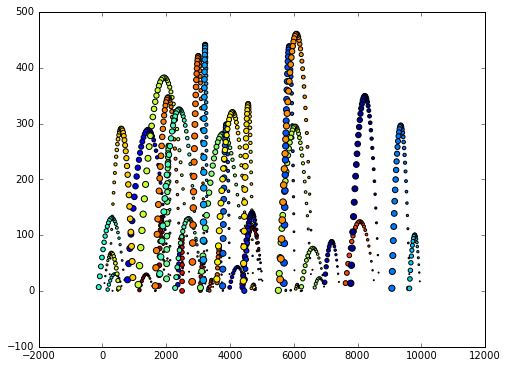

In [3]:
plt.scatter(v.x, v.y, s=v.time, c=v.ball_id)

## Creating Edges

In [4]:
g = dg.DeepGraph(v)
g

<DeepGraph object, with n=1168 node(s) and m=0 edge(s) at 0x7f23e257c0b8>

In [5]:
def x_dist(x_s, x_t):
    dx = x_t - x_s
    return dx

In [6]:
g.create_edges(connectors=x_dist)
g

<DeepGraph object, with n=1168 node(s) and m=681528 edge(s) at 0x7f23e257c0b8>

In [7]:
print(g.e)

                    dx
s    t                
0    1     6989.000000
     2    -1202.000000
     3     5747.000000
     4     3306.000000
     5     2812.000000
...                ...
1164 1166   -92.682585
     1167  -114.699250
1165 1166  2432.504327
     1167  2410.487662
1166 1167   -22.016665

[681528 rows x 1 columns]


Let's say we're only interested in creating edges between nodes with a x-distance smaller than 1000. Then we may additionally define a **selector**

In [8]:
def x_dist_selector(dx, sources, targets):
    dxa = np.abs(dx)
    sources = sources[dxa <= 1000]
    targets = targets[dxa <= 1000]
    return sources, targets

In [9]:
g.create_edges(connectors=x_dist, selectors=x_dist_selector)
g

<DeepGraph object, with n=1168 node(s) and m=156938 edge(s) at 0x7f23e257c0b8>

In [10]:
print(g.e)

                   dx
s    t               
0    6     416.000000
     7     848.000000
     19   -973.000000
     24    437.000000
     38    778.000000
...               ...
1162 1167  -44.033330
1163 1165  349.176351
1164 1166  -92.682585
     1167 -114.699250
1166 1167  -22.016665

[156938 rows x 1 columns]


There is, however, a much more efficient way of creating edges that involve a simple distance threshold such as the one above

## Creating Edges on a FastTrack

In [11]:
g.v.sort_values('x', inplace=True)

In [12]:
g.create_edges_ft(ft_feature=('x', 1000))
g

<DeepGraph object, with n=1168 node(s) and m=156938 edge(s) at 0x7f23e257c0b8>

Let's compare the efficiency

In [13]:
%timeit -n3 -r3 g.create_edges(connectors=x_dist, selectors=x_dist_selector)

3 loops, best of 3: 604 ms per loop


In [14]:
%timeit -n3 -r3 g.create_edges_ft(ft_feature=('x', 1000))

3 loops, best of 3: 166 ms per loop


In [15]:
def y_dist(y_s, y_t):
    dy = y_t - y_s
    return dy

def time_dist(time_t, time_s):
    dt = time_t - time_s
    return dt

def y_dist_selector(dy, sources, targets):
    dya = np.abs(dy)
    sources = sources[dya <= 100]
    targets = targets[dya <= 100]
    return sources, targets

def time_dist_selector(dt, sources, targets):
    dta = np.abs(dt)
    sources = sources[dta <= 1]
    targets = targets[dta <= 1]
    return sources, targets

In [16]:
g.create_edges_ft(ft_feature=('x', 100),
                  connectors=[y_dist, time_dist],
                  selectors=[y_dist_selector, time_dist_selector])
g

<DeepGraph object, with n=1168 node(s) and m=1899 edge(s) at 0x7f23e257c0b8>

In [17]:
print(g.e)

         dt         dy       ft_r
s   t                            
890 867  -1  19.311136  33.415831
867 843  -1  17.678482  33.415831
843 818  -1  16.045829  33.415831
818 792  -1  14.413176  33.415831
792 766  -1  12.780523  33.415831
...      ..        ...        ...
244 203  -1 -10.825226  15.455612
203 159  -1 -12.457879  15.455612
159 114  -1 -14.090532  15.455612
114 65   -1 -15.723185  15.455612
65  16   -1 -17.355838  15.455612

[1899 rows x 3 columns]


(1000, 3000)

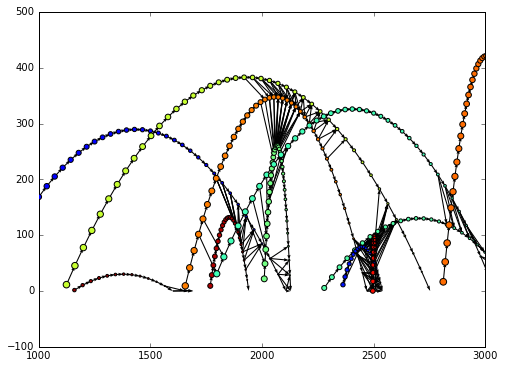

In [18]:
obj = g.plot_2d('x', 'y', edges=True, 
                kwds_scatter={'c': g.v.ball_id, 's': g.v.time})
obj['ax'].set_xlim(1000,3000)

## Graph Partitioning

## Graph Interfaces

## Plotting Methods